In [1]:
import math
import random

In [87]:
class Value:
    def __init__(self, data, label='', _op='', _children=()):
        self.data = data
        self._op = _op
        self._prev = set(_children)
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
        
    def __repr__(self) :
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, _op='+', _children=(self, other))
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__ (self, other):
        return self+other
    
    
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1
    
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, _op='*', _children=(self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other) :
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, _children = (self,), _op= f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out   

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children = (self, ), _op = 'tanh')

        def _backward():
              self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    
    def exp(self):
        out = Value(math.exp(self.data), _children=(self, ), _op='exp')
        def _backward():
            self.grad += out.data
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        rev_topo = list(reversed(topo))
        for node in rev_topo:
            node._backward()

In [88]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [89]:
a = Value(.5, 'a')
b = Value(1.0, 'c')
c = a + b; c.label = 'c'
d = Value(0.2, 'd')
L = c * d; L.label = "L"
#Ltan = L.tanh(); Ltan.label="ltan"
Lexp = L.exp(); Lexp.label="Lexp"
Lexp.backward()

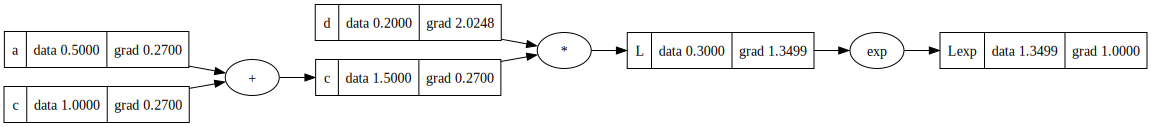

In [90]:
draw_dot(Lexp)

## Single neuron

In [91]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

## Layer of Neurons

In [92]:
class Layer:
      def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

      def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

      def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
            

## Multi-layer perceptron

In [93]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

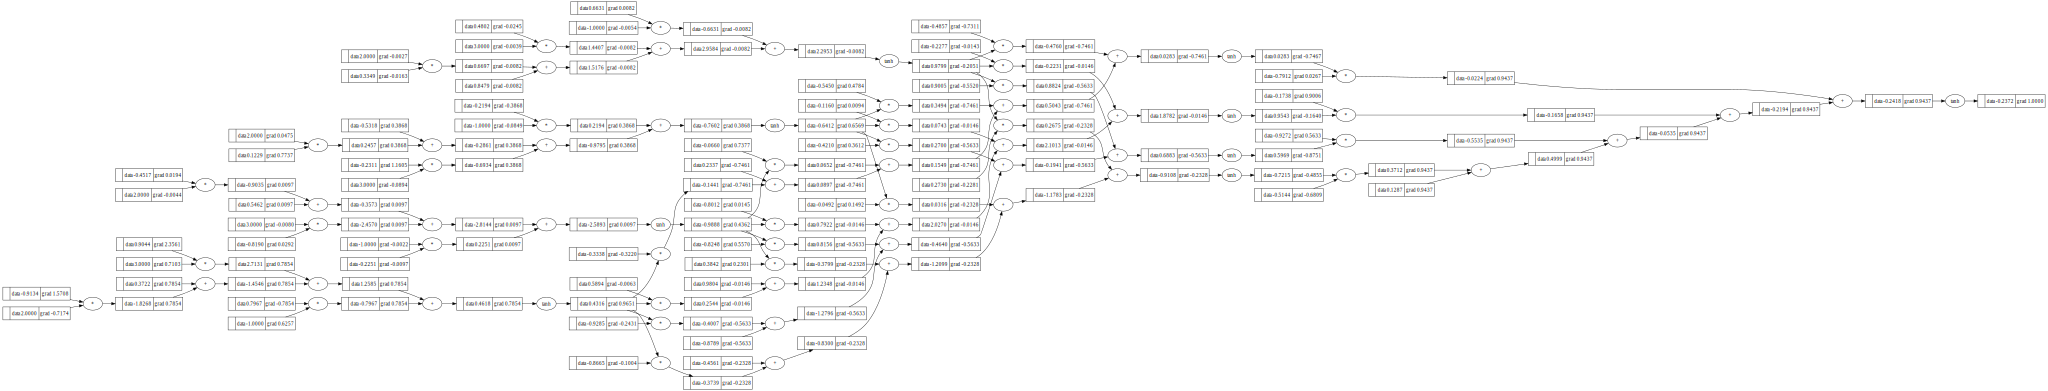

In [94]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
out = n(x)
out.backward()
draw_dot(out)

In [95]:
X = [2.0 , 3.0, 4.0]

[Value(data=0.3686970790835866), Value(data=-0.5543531305801119), Value(data=-0.7503845972130718), Value(data=0.3278267303849631)]


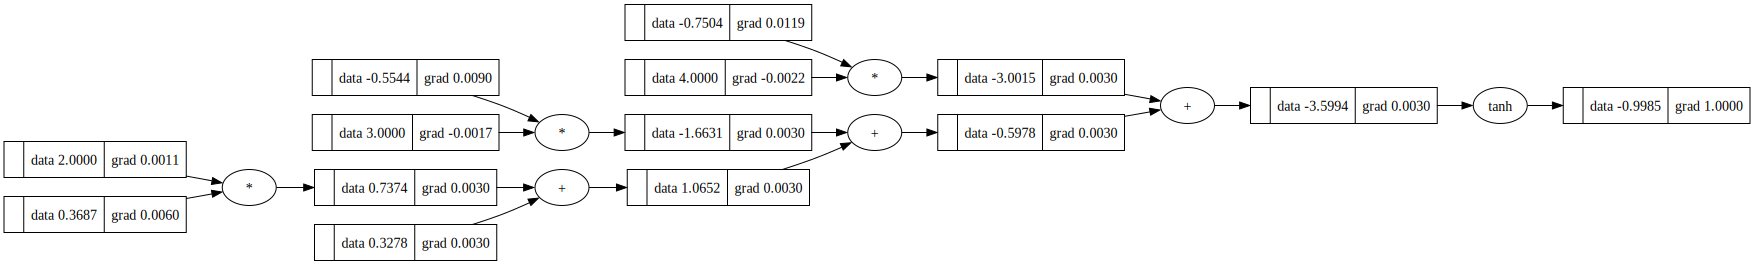

In [96]:
test = Neuron(3)
print(test.parameters())
out = test(X)
out.backward()
draw_dot(out)

In [97]:
test1 = Layer(3, 2)
#print(test1.parameters())
out = test1(X)
print(test1.parameters())
print(out)

[Value(data=0.06946801482346432), Value(data=-0.07081430234154906), Value(data=0.2474233473203986), Value(data=-0.7291082203391022), Value(data=0.26981047343380915), Value(data=0.9121382863201246), Value(data=-0.4899159404352855), Value(data=0.032678433887630476)]
[Value(data=0.18492594467528448), Value(data=0.8738289853066222)]


## Gradient descent and optimisation

In [74]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [75]:
epochs = 20
learn_rate = 0.5
n = MLP(3, [4, 4, 1])
ypred=[n(x) for x in xs]
print("before training")
ypred

before training


[Value(data=-0.18111012779724892),
 Value(data=0.7563101283420065),
 Value(data=0.2960660880069137),
 Value(data=0.2678909189417971)]

In [76]:
#training
for k in range(epochs):
    #forward pass
    ypred=[n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)


TypeError: unsupported operand type(s) for -: 'float' and 'Value'

In [77]:
print("after training")
ypred

after training


[Value(data=-0.18111012779724892),
 Value(data=0.7563101283420065),
 Value(data=0.2960660880069137),
 Value(data=0.2678909189417971)]

In [78]:
ypred=[n(x) for x in xs]
loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
loss.label = "loss"
for p in n.parameters():
    p.grad = 0.0
loss.backward()
for p in n.parameters():
    p+= -0.1*p.grad
print(loss.data)
draw_dot(loss)

TypeError: unsupported operand type(s) for -: 'float' and 'Value'